The following notebook has been forked from: https://www.kaggle.com/akensert/use-classifier-with-tf2-0-gradient-tape and only modified to respect the experimentation repeteability and metrics obtention.

In [1]:
import tensorflow as tf
import numpy as np
import random
import os


def set_seeds(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 21937
set_seeds(SEED)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import tensorflow_hub as hub
import tensorflow as tf
import gc
import os
from scipy.stats import spearmanr
from math import floor, ceil

np.set_printoptions(suppress=True)

#### 1. Read data

In [3]:
PATH = '../input/google-quest-challenge/'

df_train = pd.read_csv(PATH+'train.csv')
df_test = pd.read_csv(PATH+'test.csv')
df_sub = pd.read_csv(PATH+'sample_submission.csv')
print('train shape =', df_train.shape)
print('test shape =', df_test.shape)

output_categories = list(df_train.columns[11:])
input_categories = list(df_train.columns[[1,2,5,9,10]])
print('\noutput categories:\n\t', output_categories)
print('\ninput categories:\n\t', input_categories)

train shape = (6079, 41)
test shape = (476, 11)

output categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

input categories:
	 ['question_title', 'question_body', 'answer', 'category', 'host']


#### 2. Convert plain text to USE vectors

In [4]:
def convert_to_use_vectors(df, embed):
    t = np.empty((len(df), 512))
    q = np.empty((len(df), 512))
    a = np.empty((len(df), 512))
    for i, instance in tqdm(df.iterrows()):
        t[i, :] = embed([str(instance.question_title)])["outputs"].numpy().flatten()
        q[i, :] = embed([str(instance.question_body)])["outputs"].numpy().flatten()
        a[i, :] = embed([str(instance.answer)])["outputs"].numpy().flatten()
    return t, q, a

embed = hub.load('../input/universalsentenceencoderlarge4/')

train_t, train_q, train_a = convert_to_use_vectors(df_train, embed)
test_t, test_q, test_a = convert_to_use_vectors(df_test, embed)

#### 2b. Add axuillary data for additional inputs

In [5]:
def onehot_features(train, test, column):
    from pandas.api.types import CategoricalDtype
    categories = train[column].dropna().unique()
    train[column] = train[column].astype(CategoricalDtype(categories))
    test[column] = test[column].astype(CategoricalDtype(categories))

    train = pd.get_dummies(train[column])
    test = pd.get_dummies(test[column])
    return train, test


train_category, test_category = onehot_features(df_train, df_test, 'category')
assert all(train_category.columns == test_category.columns), 'Mismatch between train and test set'
train_category = np.asarray(train_category, dtype=np.float32)
test_category = np.asarray(test_category, dtype=np.float32)
print('train category one hot shape = {}'.format(train_category.shape))
print('test category one hot shape = {}'.format(test_category.shape))

train_host, test_host = onehot_features(df_train, df_test, 'host')
assert all(train_host.columns == test_host.columns), 'Mismatch between train and test set'
train_host = np.asarray(train_host, dtype=np.float32)
test_host = np.asarray(test_host, dtype=np.float32)
print('train host one hot shape = {}'.format(train_host.shape))
print('test host one hot shape = {}'.format(test_host.shape))

train category one hot shape = (6079, 5)
test category one hot shape = (476, 5)
train host one hot shape = (6079, 63)
test host one hot shape = (476, 63)


#### 3. Define Spearman metric

In [6]:
def compute_spearmanr(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rho = spearmanr(tcol, pcol).correlation
        if np.isfinite(rho):
            rhos.append(rho)
    return np.mean(rhos)

#### 4. Create helper functions and Model

In [7]:
def initialize_weights(init, shape):
    W = tf.Variable(init(shape))
    b = tf.Variable(0.)
    return W, b

def dense_hidden(x, w, b, dropout_rate, training):
    x = tf.matmul(x, w) + b
    x = tf.nn.relu(x)
    if training:
        return tf.nn.dropout(x, dropout_rate)
    return x

def dense_output(x, w, b):
    x = tf.matmul(x, w) + b
    x = tf.nn.sigmoid(x)
    return x


class NeuralNet(tf.keras.Model):

    def __init__(self, inputs_units, dense_units, dropout_rates, aux_units, name="NeuralNet"):
        """
        Parameters
        ----------
        input_units : list (3 elements)
            length of (1) use vector, (2) one-hot vec cateogry & (3) one-hot vec host
            for an input example, i.e. input_units=[512, 5, 63]
        dense_units : list
            containing the number of units that will be used for each layer
        dropout_rates : list 
            the rates of dropout for each of the dense_units/layers (except output layer)
        aux_units: int
            number of units for the two auxillary layers
        
        """
        
        super(NeuralNet, self).__init__(name)
        
        glorot = tf.initializers.glorot_uniform()
        self.dropout_rates = dropout_rates
        self.W1, self.b1 = initialize_weights(glorot, (input_units[0], dense_units[0]))
        self.W2, self.b2 = initialize_weights(glorot, (dense_units[0], dense_units[1]))
        self.W3, self.b3 = initialize_weights(glorot, (dense_units[0], dense_units[2]))
        self.W4, self.b4 = initialize_weights(glorot, (dense_units[0], dense_units[3]))
        self.W5, self.b5 = initialize_weights(
            glorot, (dense_units[1]+dense_units[2]+dense_units[3]+(aux_units*2), dense_units[4]))
        
        self.W_aux1, self.b_aux1 = initialize_weights(glorot, (inputs_units[1], aux_units))
        self.W_aux2, self.b_aux2 = initialize_weights(glorot, (inputs_units[2], aux_units))
    
    @tf.function
    def call(self, inputs, training=False):
        
        # sharing first layer ("text" input)
        x0 = dense_hidden(inputs[0], self.W1, self.b1, self.dropout_rates[0], training)
        x1 = dense_hidden(inputs[1], self.W1, self.b1, self.dropout_rates[0], training)
        x2 = dense_hidden(inputs[2], self.W1, self.b1, self.dropout_rates[0], training)
        # no more sharing
        x0 = dense_hidden(x0, self.W2, self.b2, self.dropout_rates[1], training)
        x1 = dense_hidden(x1, self.W3, self.b3, self.dropout_rates[2], training)
        x2 = dense_hidden(x2, self.W4, self.b4, self.dropout_rates[3], training)
        
        # aux layers
        # category input -> hidden_layer
        x3 = dense_hidden(inputs[3], self.W_aux1, self.b_aux1, self.dropout_rates[-1], training)
        # host input -> hidden layer
        x4 = dense_hidden(inputs[4], self.W_aux2, self.b_aux2, self.dropout_rates[-1], training)
        
        # concat and output
        x = tf.concat([x0, x1, x2, x3, x4], axis=1)
        return dense_output(x, self.W5, self.b5)

#### 5. Creating functions for creating tf.Dataset and for Model training 

With Gradient Tape and eager execution you have a lot of control over your training steps. You can track computations and calculate gradients with respect to the variables of your choice. For tracking `tf.constant` we need to do `tape.watch(constant)`, however, trainable variables are automatically watched over.<br>

Be aware that computing metric during training may add significant time to the training loop.

In [8]:
def create_dataset(inputs, outputs=None, batch_size=8):
    dataset_inputs = tf.data.Dataset.from_tensor_slices(inputs)
    if outputs is not None:
        dataset_outputs = tf.data.Dataset.from_tensor_slices(outputs)
        return tf.data.Dataset.zip((dataset_inputs, dataset_outputs)).batch(batch_size)
    return dataset_inputs.batch(batch_size)

def get_train_step_fn():
    """This is a workaround so that the tf.function decorator
    works for the cross-validation. i.e. when it's called 
    a second and third time etc.."""
    @tf.function
    def train_step(model, loss_function, optimizer, metric, x, y):
        with tf.GradientTape() as tape:
            pred = model(x, training=True)
            loss = loss_function(y, pred)
        # compute gradients of all trainable variables with respect to the loss
        grad = tape.gradient(loss, model.trainable_variables)
        # apply gradients to the variables/updating them
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        # batch metric calculation
        metric(y, pred)

        return loss, pred
    return train_step


def compute_spearmanr2(preds, trues):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return np.nanmean(rhos), rhos

def train_and_predict(model, loss_function, optimizer, metric, 
                      train_dataset, valid_dataset, test_dataset, num_epochs):
    
    train_step = get_train_step_fn()
    valid_snapshot_preds, test_snapshot_preds = [], []
    train_scores, valid_scores = [0.], [0.]
    for epoch in range(num_epochs):
        
        # training loop
        epoch_loss = 0.
        train_preds, train_trues = np.empty((0, 30), np.float32), np.empty((0, 30), np.float32)
        for batch, (x_train, y_train) in enumerate(train_dataset):
            loss, pred = train_step(model, loss_function, optimizer, metric, x_train, y_train)
            epoch_loss += loss
            train_trues = np.append(train_trues, y_train.numpy(), axis=0)
            train_preds = np.append(train_preds, pred.numpy(), axis=0)
            
        train_scores.append(compute_spearmanr(train_trues, train_preds))
        
        # validation loop
       
        valid_preds, valid_trues = np.empty((0, 30), np.float32), np.empty((0, 30), np.float32)
        for (x_val, y_val) in valid_dataset:
            valid_preds = np.append(valid_preds, model(x_val, training=False).numpy(), axis=0) 
            valid_trues = np.append(valid_trues, y_val.numpy(), axis=0)
        valid_snapshot_preds.append(valid_preds)
        valid_scores.append(compute_spearmanr(valid_trues, np.average(valid_snapshot_preds, axis=0)))
        
        
        current_loss = epoch_loss/(batch+1)        
        score, rho_cols = compute_spearmanr2(valid_preds, valid_trues)
        print(f'epoch = {epoch}, train_loss = {current_loss}, valid_spearman = {score}')
        if epoch == num_epochs-1:
            rho_print = [print(output_categories[i] + " rho: " + str(rho_cols[i]) ) for i in range(0, len(output_categories))]  
        
        
        # manually resetting metric
        metric.reset_states()
        
        # test loop 
        test_preds = np.empty((0, 30), np.float32)
        for x_test in test_dataset:
            test_preds = np.append(test_preds, model(x_test, training=False).numpy(), axis=0) 
        test_snapshot_preds.append(test_preds)

        
    return valid_snapshot_preds, test_snapshot_preds, train_scores, valid_scores


#### 6. Cross validation 

Finally training and predicting with the model.

In [9]:
input_units = [512, 5, 63] # use, cat, host input size
dense_units = [512, 256, 256, 256, 30] # for shared layer, non-shared layers, output layer
aux_units = 256 # for aux layers
dropout_rates = [0.3, 0.2, 0.2, 0.2] # for shared layer, non-shared layers
num_folds = 5
num_epochs = 15
learning_rate = 5e-4
batch_size = 64

model = None
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_function = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.CosineSimilarity()

gkf = GroupKFold(n_splits=num_folds).split(X=df_train.question_body, groups=df_train.question_body)

valid_fold_predictions = []
test_fold_predictions = []
train_fold_scores = []
valid_fold_scores = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    print("\n\nfold {:01d}".format(fold+1))
    model = NeuralNet(input_units, dense_units, dropout_rates, aux_units)

    train_dataset = create_dataset(
        (train_t[train_idx], train_q[train_idx], train_a[train_idx], 
         train_category[train_idx], train_host[train_idx]), 
         np.asarray(df_train[output_categories].iloc[train_idx]),
         batch_size)

    valid_dataset = create_dataset(
        (train_t[valid_idx], train_q[valid_idx], train_a[valid_idx], 
         train_category[valid_idx], train_host[valid_idx]), 
         np.asarray(df_train[output_categories].iloc[valid_idx]),
         batch_size)

    test_dataset = create_dataset(
        (test_t, test_q, test_a, 
         test_category, test_host),
         None,
         batch_size)
    
    valid_preds, test_preds, train_scores, valid_scores = train_and_predict(
        model, loss_function, optimizer, metric,
        train_dataset, valid_dataset, test_dataset, num_epochs)

    valid_fold_predictions.append(valid_preds)
    test_fold_predictions.append(test_preds)
    train_fold_scores.append(train_scores)
    valid_fold_scores.append(valid_scores)



fold 1
epoch = 0, train_loss = 0.4656933844089508, valid_spearman = 0.2340539565570501
epoch = 1, train_loss = 0.3938092291355133, valid_spearman = 0.31301234231947056
epoch = 2, train_loss = 0.38064947724342346, valid_spearman = 0.34535178328198934
epoch = 3, train_loss = 0.3730466961860657, valid_spearman = 0.3579933516126255
epoch = 4, train_loss = 0.3682281970977783, valid_spearman = 0.3650030988015413
epoch = 5, train_loss = 0.364694207906723, valid_spearman = 0.3692809515368369
epoch = 6, train_loss = 0.36164167523384094, valid_spearman = 0.372101306737403
epoch = 7, train_loss = 0.35886818170547485, valid_spearman = 0.37268814586818455
epoch = 8, train_loss = 0.3563489019870758, valid_spearman = 0.37361145680357016
epoch = 9, train_loss = 0.3537922501564026, valid_spearman = 0.37339136523028
epoch = 10, train_loss = 0.35159507393836975, valid_spearman = 0.37305692895079434
epoch = 11, train_loss = 0.34914132952690125, valid_spearman = 0.3721951871321489
epoch = 12, train_loss 

In [10]:
# check spearmanr for each columns
# def compute_spearmanr(trues, preds):
#     rhos = []
#     for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
#         rho = spearmanr(tcol, pcol).correlation
#         if np.isfinite(rho):
#             rhos.append(rho)
#     return rhos, np.mean(rhos)

# gkf = GroupKFold(n_splits=num_folds).split(X=df_train.question_body, groups=df_train.question_body)
# for fold, (train_idx, valid_idx) in enumerate(gkf):
#     print(compute_spearmanr(df_train[output_categories].iloc[valid_idx].values, np.average(valid_fold_predictions[fold], axis=0)))
#     print("---"*20)

#### 7. Plot spearmanr vs epochs

The way the train scores are obtained makes the comparison with the valid scores/spearmanr far from perfect. The train preds are obtained for each batch during the epoch, and is thus heavily influenced by earlier examples that epoch

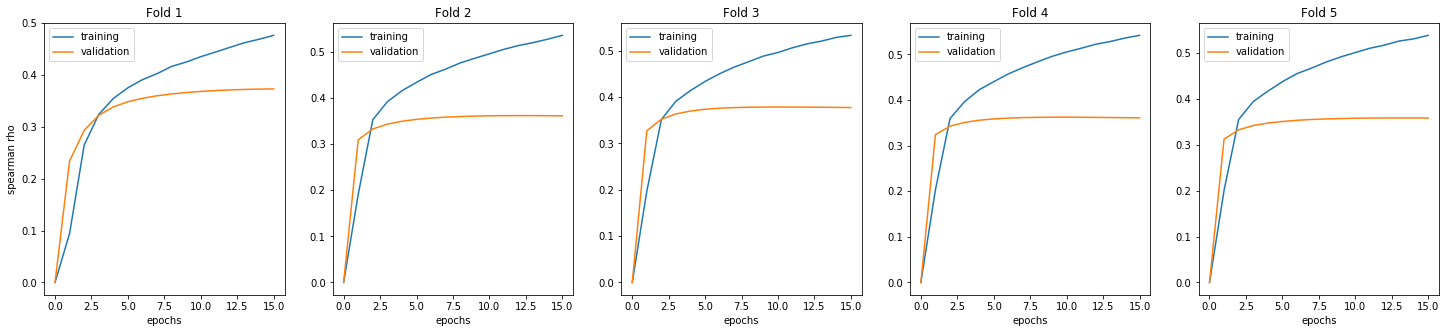

In [11]:
fig, axes = plt.subplots(1, num_folds, figsize=(num_folds*5, num_folds))

for i, ax in enumerate(axes.reshape(-1)):
    ax.plot(np.linspace(0., len(train_fold_scores[i])-1, len(train_fold_scores[i])), 
            train_fold_scores[i], label='training')
    ax.plot(np.linspace(0., len(valid_fold_scores[i])-1, len(valid_fold_scores[i])), 
            valid_fold_scores[i], label='validation')
    ax.set_title("Fold {}".format(i+1))
    if i == 0:
        ax.set_ylabel("spearman rho")
    ax.set_xlabel("epochs")
    ax.legend()

#### 8. Submit test predictions

In [12]:
# if snapshot preds:
def compute_final_predictions(test_fold_predictions):
    snapshot_averages = [np.average(test_fold_predictions[i], axis=0) for i in range(len(test_fold_predictions))]
    return np.mean(snapshot_averages, axis=0)

df_sub.iloc[:, 1:] = compute_final_predictions(test_fold_predictions)

In [13]:
df_sub.to_csv("submission.csv", index=False)